In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()
test_df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,7RYZGMKJIR,32,131645,43797,802,23,2,6.10,24,0.13,High School,Full-time,Divorced,Yes,No,Other,No
1,JDL5RH07AM,61,134312,18402,369,87,2,12.99,60,0.59,High School,Self-employed,Single,No,No,Business,Yes
2,STAL716Y79,55,115809,151774,563,3,3,5.51,48,0.82,Bachelor's,Full-time,Single,Yes,Yes,Other,Yes
3,SO0KKJ3IQB,58,94970,55789,337,24,1,23.93,36,0.77,Bachelor's,Unemployed,Divorced,No,No,Business,No
4,T99CWTYDCP,63,71727,189798,451,52,3,22.05,48,0.44,PhD,Unemployed,Single,Yes,No,Auto,No


In [6]:

train_df.isnull().sum()
test_df.isnull().sum()

train_df.describe()
test_df.describe()


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio
count,109435.000000,109435.000000,109435.000000,109435.000000,109435.000000,109435.000000,109435.000000,109435.000000,109435.000000
mean,43.536483,82487.391036,127486.538667,574.665948,59.576315,2.501037,13.496206,36.086298,0.500263
std,15.015927,38966.033421,70703.100952,158.800306,34.548087,1.118149,6.647329,16.928304,0.231246
min,18.000000,15003.000000,5002.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000
25%,31.000000,48745.000000,66173.500000,437.000000,30.000000,2.000000,7.750000,24.000000,0.300000
50%,44.000000,82545.000000,127345.000000,575.000000,60.000000,3.000000,13.500000,36.000000,0.500000
75%,57.000000,116184.000000,188674.000000,712.000000,89.000000,4.000000,19.270000,48.000000,0.700000
max,69.000000,149999.000000,249995.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000


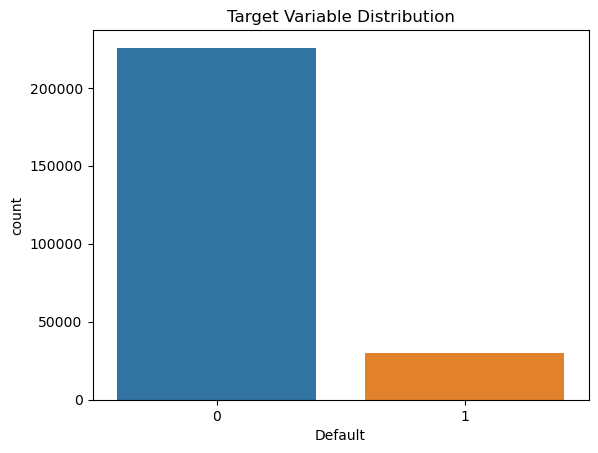

In [8]:
sns.countplot(data=train_df, x="Default")
plt.title("Target Variable Distribution")
plt.show()

In [9]:
target = "Default"
y = train_df[target]
X = train_df.drop(columns=[target])

In [10]:
categorical_cols = ["Education", "EmploymentType", "MaritalStatus", "LoanPurpose"]
binary_cols = ["HasMortgage", "HasDependents", "HasCoSigner"]
numerical_cols = [col for col in X.columns if col not in categorical_cols + binary_cols + ["LoanID"]]


In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=7, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=SEED),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=4, random_state=SEED),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=SEED),
    "CatBoost": CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=0, random_state=SEED)}


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
best_auc = 0
best_model_name = ""
best_pipeline = None
auc_scores = {}

In [16]:
X = train_df.drop(columns=["Default", "LoanID"])
test_ids = test_df["LoanID"]
test_df = test_df.drop(columns=["LoanID"])

# Encode features
X_encoded = encode_data(X)
test_encoded = encode_data(test_df)


In [17]:
print("\nEvaluating models with 5-fold CV:\n")
for name, model in models.items():
    X_input = X_encoded if name in ["Logistic Regression", "Decision Tree"] else X

    pipeline = Pipeline([
        ("preprocessor", preprocessor) if name not in ["Logistic Regression", "Decision Tree"] else ("identity", "passthrough"),
        ("classifier", model)
    ])
    scores = cross_val_score(pipeline, X_input, y, cv=cv, scoring='roc_auc')
    mean_score = scores.mean()
    auc_scores[name] = mean_score
    print(f"{name}: AUC = {mean_score:.4f}")
    if mean_score > best_auc:
        best_auc = mean_score
        best_model_name = name
        best_pipeline = pipeline
        final_X = X_input


Evaluating models with 5-fold CV:

Logistic Regression: AUC = 0.7268
Decision Tree: AUC = 0.7127


NameError: name 'preprocessor' is not defined

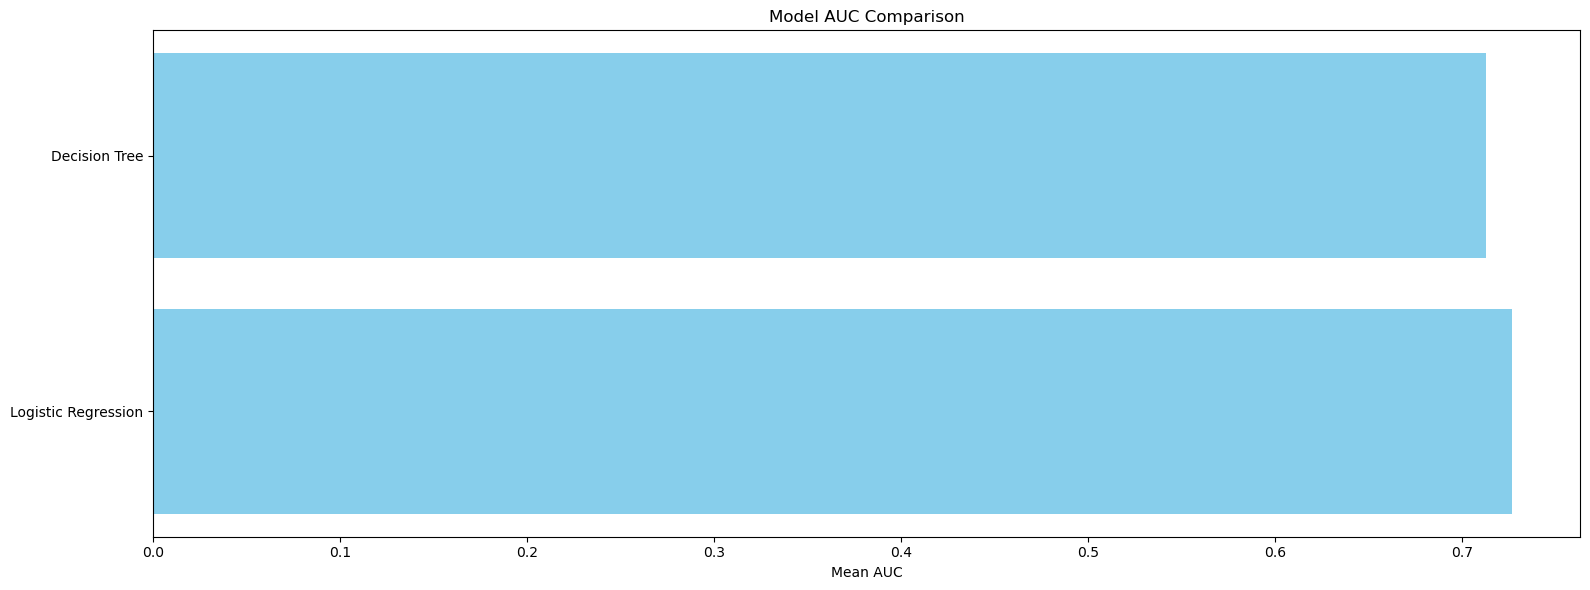


✅ Best Model: Logistic Regression with AUC = 0.7268


In [22]:
plt.figure(figsize=(16,6))
plt.barh(list(auc_scores.keys()), list(auc_scores.values()), color='skyblue')
plt.xlabel("Mean AUC")
plt.title("Model AUC Comparison")
plt.tight_layout()
plt.show()

print(f"\n✅ Best Model: {best_model_name} with AUC = {best_auc:.4f}")

In [23]:
best_pipeline.fit(final_X, y)

Pipeline(steps=[('identity', 'passthrough'),
                ('classifier',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

In [25]:
X_test_input = test_encoded if best_model_name in ["Logistic Regression", "Decision Tree"] else test_df
predicted_proba = best_pipeline.predict_proba(X_test_input)[:, 1]


In [28]:
prediction_df = pd.DataFrame({
    "LoanID": test_ids,
    "predicted_probability": predicted_proba
})


assert prediction_df.shape == (109435, 2)
assert list(prediction_df.columns) == ["LoanID", "predicted_probability"]

prediction_df.to_csv("submission.csv", index=False)
print("✅ submission.csv has been created.")

✅ submission.csv has been created.


In [29]:
from sklearn.metrics import accuracy_score

y_pred = best_pipeline.predict(final_X)
acc = accuracy_score(y, y_pred)
print(f"Training Accuracy of Best Model: {acc:.4f}")


Training Accuracy of Best Model: 0.8843
